### Model builing

* Compute similarity ( Eulidean distance)
  * Compute the similarity matrix that show how similar each song to other songs 
* Implement Recommendation Function
* pass user recomendtion as argument in the recommendaiton funtion
  * it's going to be an object either

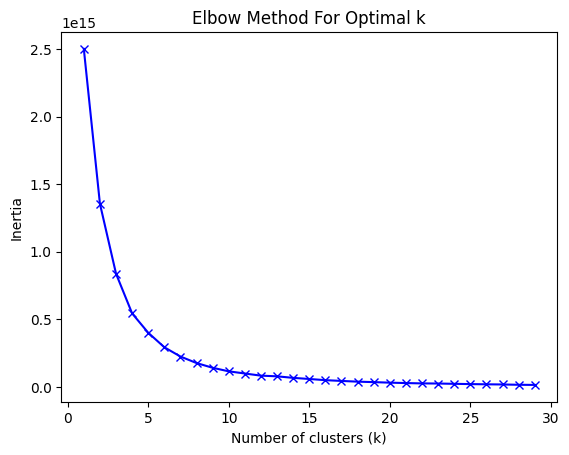

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Implement K-means clustering

#read the file
df = pd.read_csv("../dataset/features.csv")

# drop non numerical value for clustering
df_clustering = df.drop(columns=['artists', 'id', 'name', 'release_date'])

# finding optimal number of cluster using Elbow method
# a list to store ineria value (sum of squared distances of samples to their closest cluster center)
inertia_list = []

K_values = range(1,30)

for k in K_values: 
    # initlize k means
    k_Means = KMeans(n_clusters=k, random_state=42)
    # fit the model 
    k_Means.fit(df_clustering)
    # store k_Values to the list 
    inertia_list.append(k_Means.inertia_)

# plot the inertia to find the optimal k value (number of clusters)
plt.plot(K_values, inertia_list, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [23]:
# Based on the plot and few testings, the optimal amount of cluster is aorund 7

#initlizing Kmmeans
K_means = KMeans(n_clusters=7, random_state=42)

# fit the data
K_means.fit(df_clustering) 

# assign songs to clusters
df['cluster'] = K_means.labels_

# Save the clustering result
df.to_csv("../dataset/clustered_songs.csv", index=False)

# Display the first few rows
print(df.head(1))


# Number of songs in each cluster
print(f'\n Numebr of songs in each clusetr:\n')
print(df['cluster'].value_counts())




   acousticness              artists  danceability  duration_ms  energy  \
0         0.995  ['Carl Woitschach']         0.708       158648   0.195   

   explicit                      id  instrumentalness  key  liveness  ...  \
0         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   10     0.151  ...   

                          name  popularity release_date  speechiness  \
0  Singende Bataillone 1. Teil         0.0         1928       0.0506   

      tempo  valence  year   key_sin  key_cos  cluster  
0  0.485348    0.779  1928 -0.866025      0.5        4  

[1 rows x 22 columns]

 Numebr of songs in each clusetr:

cluster
1    74040
2    42957
4    36311
0    12737
5     3282
3      537
6       45
Name: count, dtype: int64


#### **Recommendation fucntion**

In [1]:
## def get_recommendations(selected_song_ids, df, K_means, num_recommendations=10):
    # Retrieve the clusters of the selected songs
from sklearn.metrics.pairwise import euclidean_distances

def get_recommendations(selected_song_ids, df, K_means, num_recommendations=10):

    # check if id is not empty
    if selected_song_ids is None:
        raise ValueError("selected_song_ids must be provided.")

    # Rertieve the features
    # drop unecessory cols
    # 
    song_features = df[df['id'].isin(selected_song_ids)].drop(columns=['artists', 'id', 'name', 'release_date', 'cluster'])
    user_profile_vector = song_features.mean().values

    # to predict which cluster the user profile vector belong too 
    user_cluster = K_means.predict([user_profile_vector])[0]

    # get the candidate songs (potential recommendation)
    candidate_songs = df[df['cluster'] == user_cluster]

    # remove songs user already selected
    candidate_songs = candidate_songs[~candidate_songs['id'].isin(selected_song_ids)]

    # Compute similarities between the user profile and candidate using euclidean distance
    candidate_features = candidate_songs.drop(columns=['artists', 'id', 'name', 'release_date', 'cluster']).values
    distances = euclidean_distances([user_profile_vector], candidate_features)[0]

    # Add distances to the candidate songs DataFrame
    candidate_songs = candidate_songs.copy()
    candidate_songs['distance'] = distances

    # Recommend the top N songs based on the closest distances
    recommended_songs = candidate_songs.sort_values('distance').head(num_recommendations)

    return recommended_songs[['artists', 'name', 'id']]
